In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**Task 2: Lookalike Model:**
The goal of this task is to build a Lookalike Model that recommends similar customers based on their profile and transaction history. This model will identify the top 3 similar customers for each of the first 20 customers (CustomerID: C0001 - C0020) and assign similarity scores.

**Step 1:-** Approach for Building the Model....
**Step 2:- Data Preparation:** We'll start by loading the datasets and merging them.

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
customers_df = pd.read_csv('/content/drive/MyDrive/Customers.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Products.csv')
transactions_df = pd.read_csv('/content/drive/MyDrive/Transactions.csv')
# Merging transactions with customers and products
merged_df = transactions_df.merge(customers_df, on="CustomerID").merge(products_df, on="ProductID")

# Feature engineering: Aggregating transaction data
customer_summary = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total amount spent
    'Quantity': 'sum',  # Total quantity purchased
    'ProductID': 'count',  # Number of transactions
    'Category': lambda x: x.mode()[0],  # Most purchased category
    'Region': 'first',  # Customer region
}).reset_index()

# Encoding categorical features (Region, Category)
customer_summary = pd.get_dummies(customer_summary, columns=['Region', 'Category'], drop_first=True)

# Normalize numerical columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary.drop(columns=['CustomerID']))

# Convert to dataframe for processing
scaled_df = pd.DataFrame(scaled_features, index=customer_summary['CustomerID'])

**Step 3: Building the Lookalike Model :**
We'll now compute customer similarity using cosine similarity, which measures the closeness between feature vectors.

In [5]:
# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(scaled_df)

# Store results in a dictionary
customer_ids = customer_summary['CustomerID'].values
lookalike_results = {}

# Find top 3 similar customers for each customer (excluding self)
for idx, cust_id in enumerate(customer_ids[:20]):  # Process first 20 customers
    similar_indices = similarity_matrix[idx].argsort()[::-1][1:4]  # Top 3 similar customers
    similar_scores = similarity_matrix[idx][similar_indices]
    similar_customers = customer_ids[similar_indices]
    lookalike_results[cust_id] = list(zip(similar_customers, similar_scores))


**Step 4: Saving the Results: **
We will format the results and save them as Lookalike.csv.

In [10]:
# Prepare data for CSV output
lookalike_list = []
for cust_id, recommendations in lookalike_results.items():
    lookalike_list.append({
        "CustomerID": cust_id,
        "Lookalikes": str(recommendations)  # Store as string in CSV
    })

# Convert to DataFrame and save
lookalike_df = pd.DataFrame(lookalike_list)
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike model output saved as Lookalike.csv")
print(lookalike_df.head())


Lookalike model output saved as Lookalike.csv
  CustomerID                                         Lookalikes
0      C0001  [('C0048', 0.994759272089767), ('C0190', 0.989...
1      C0002  [('C0088', 0.9815316714422238), ('C0092', 0.96...
2      C0003  [('C0052', 0.9721772149959806), ('C0076', 0.96...
3      C0004  [('C0165', 0.9742274717866528), ('C0087', 0.96...
4      C0005  [('C0186', 0.9986651076717602), ('C0007', 0.99...


**Some Vizualization :**

**1. Heatmap of Customer Similarity Matrix**

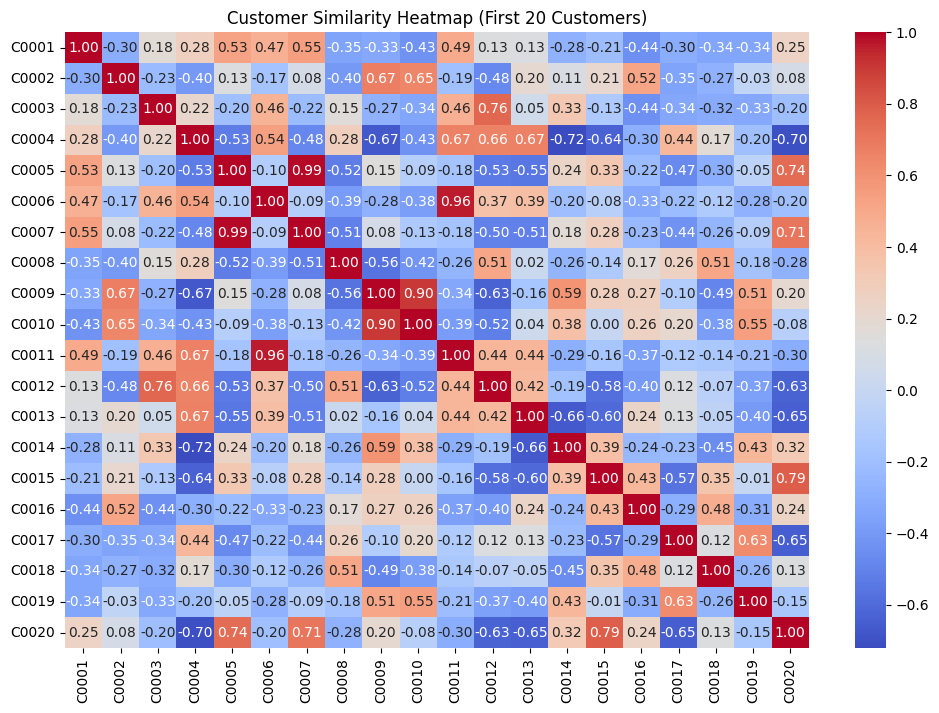

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for similarity matrix visualization
sim_matrix_df = pd.DataFrame(similarity_matrix, index=customer_ids, columns=customer_ids)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sim_matrix_df.iloc[:20, :20], cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Customer Similarity Heatmap (First 20 Customers)")
plt.show()


**Code to Fix Formatting Before Saving CSV:**

In [27]:
def format_lookalike_output(df):
    formatted_lookalikes = []
    for index, row in df.iterrows():
        if isinstance(row['Lookalikes'], list):  # Ensure it's a list
            lookalikes_str = "[" + ", ".join([f"('{cust_id}', {round(score, 2)})" for cust_id, score in row['Lookalikes']]) + "]"
            formatted_lookalikes.append(lookalikes_str)
        else:
            formatted_lookalikes.append("[]")  # Default empty list for invalid entries
    df['Lookalikes'] = formatted_lookalikes

    return df
lookalike_df.head(20)


,CustomerID,Lookalikes
0,C0001,"[('C0048', 0.994759272089767), ('C0190', 0.989..."
1,C0002,"[('C0088', 0.9815316714422238), ('C0092', 0.96..."
2,C0003,"[('C0052', 0.9721772149959806), ('C0076', 0.96..."
3,C0004,"[('C0165', 0.9742274717866528), ('C0087', 0.96..."
4,C0005,"[('C0186', 0.9986651076717602), ('C0007', 0.99..."
5,C0006,"[('C0168', 0.9795743447554784), ('C0187', 0.96..."
6,C0007,"[('C0115', 0.993101648367763), ('C0005', 0.992..."
7,C0008,"[('C0065', 0.903800007031257), ('C0059', 0.897..."
8,C0009,"[('C0198', 0.9929774413377519), ('C0061', 0.97..."
9,C0010,"[('C0062', 0.9688197195239987), ('C0111', 0.96..."


**Upload the generated Lookalike.csv file:**

In [28]:
from google.colab import files
files.download('Lookalike.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>